In [2]:
# find the shortest by using Lee algorithm, this is used for comparsion
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/home/ybiao/DRL4CR/LearnFromMazeAlgm/')

from LeeAlgm import Field
import numpy as np
import os
import re


class MazeRouting():

    def __init__(self):

        self.board = np.zeros((30,30))

        self.barriers = []
        self.start = {}
        self.finish = {}

        self.pin_max = int(np.amax(self.board))

        self.labels = []

        self.direction_map = {(-1, 0): 0, (0, 1): 1, (1, 0): 2, (0, -1): 3}

    def parseBoard(self):
        ''' Get the initial barriers from the board including terminals,
            and also get the start and end of the routing path (terminals).
        '''

        for i in range(self.board.shape[0]):
            for j in range(self.board.shape[1]):
                if self.board[i,j] == 1:
                    self.barriers.append((i,j))
                elif self.board[i,j] != 0:
                    if self.board[i,j] in self.start:
                        self.finish[self.board[i,j]] = (i,j)
                    else:
                        self.start[self.board[i,j]] = (i,j)
                    self.barriers.append((i,j))

    def getRoutingPath(self, pin_idx):

        self.barriers.remove(self.start[pin_idx])
        self.barriers.remove(self.finish[pin_idx])

        field = Field(len=30, start=self.start[pin_idx], finish=self.finish[pin_idx],
                      barriers=self.barriers)
        field.emit()

        path = field.get_path()

        return list(path)

    def GenRoutingData(self, path):
        ''' Given the routing path by maze algorithm of one pair of terminals,
            generate and save the data for RL: the number in the path increase as the path gets longer, \
            and other blocks on the board are 1s
        '''
        path_x = []
        path_y = []
        path_num = self.pin_max + 1

        for p in range(len(path)-1):
            # generate board
            self.barriers.append(path[p])
            self.board[path[p]] = path_num
            path_x.append(path[p][0])
            path_y.append(path[p][1])
            path_num += 1

        self.board[(path_x, path_y)] = 1

    def run(self):

        self.parseBoard()
        wire_length = 0

        for pin_idx in range(2, self.pin_max+1):
            try:
                path = self.getRoutingPath(pin_idx)
                wire_length += len(path)
                self.GenRoutingData(path)
            except:
                print("No path left")
            
        return wire_length

    def reset(self, board):

        self.board = board

        self.barriers = []
        self.start = {}
        self.finish = {}

        self.data_idx = 0

        self.pin_max = int(np.amax(board))

        self.labels = []

# For plotting routing path on the board
from testAction import test_policy

def checkNeigh(cood1, cood2):
    direction_list = [(-1, 0), (0, 1), (1, 0), (0, -1)]
    for d in direction_list:
        if (cood1[0]+d[0], cood1[1]+d[1]) == cood2:
            return True
    return False

def get_path_rate(it_range, rew_type):
    # getting path
    direction_list = [(-1, 0), (0, 1), (1, 0), (0, -1)]

    plot_data_mean = []
    plot_data_std = []
    for it in it_range:

        num_fails = 0
        shortest_lengths = []
        routing_lengths = []
        for idxB in [2,3,4,5,6,8,10,11,14,15,18,19,20,22,24,26,28,30]:
#         for idxB in [0,1,2,3,4,5,6,7,8,9,10,11,12,14,15,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]:

            boardfile = '../server_code/test_boards/board'+str(idxB)+'.csv'
            board = np.genfromtxt(boardfile, delimiter=',')
            initialState = test_policy(board)

            start = initialState.start
            finish = initialState.finish

            pair_idx = 2
            try:
                actions = np.genfromtxt("./Actions_"+rew_type+str(it)+"/saved_actions_"+str(idxB)+".csv", delimiter=',')

                paths_x = []
                paths_y = []

                path_x = [initialState.start[pair_idx][0]]
                path_y = [initialState.start[pair_idx][1]]

                for action_idx in actions:

                    action = direction_list[int(action_idx)]
                    initialState.takeAction(action)

                    if initialState.action_node is not None and pair_idx in finish:

                        if checkNeigh(initialState.action_node, finish[pair_idx]):

                            path_x.append(initialState.action_node[0])
                            path_y.append(initialState.action_node[1])

                            path_x.append(finish[pair_idx][0])
                            path_y.append(finish[pair_idx][1])

                            pair_idx += 1
                            paths_x.append(path_x)
                            paths_y.append(path_y)

                            path_x = []
                            path_y = []

                        else:
                            path_x.append(initialState.action_node[0])
                            path_y.append(initialState.action_node[1])

                if len(paths_x)<5:
                    paths_x.append(path_x)
                    paths_y.append(path_y)
                    num_fails += 1
        #                 print(idxB)
                else:
                    if idxB==23:
                        shortest_length = 99
                    else:
                        routing = MazeRouting()
                        board = np.genfromtxt(boardfile, delimiter=',')
                        routing.reset(board)
                        shortest_length = routing.run()

                    routing_length = len(actions)+5
                    shortest_lengths.append(shortest_length)
                    routing_lengths.append(routing_length)
            except:
                print("the board is not in the folder")  
        shortest_lengths = np.array(shortest_lengths)
        routing_lengths = np.array(routing_lengths)
        #     print(shortest_lengths, routing_lengths)
        rate = (routing_lengths - shortest_lengths)/shortest_lengths
        plot_data_mean.append(np.mean(rate))
        plot_data_std.append(np.std(rate))
#         print(np.mean(rate_best))
    return plot_data_mean, plot_data_std

In [11]:
best_mean, best_std = get_path_rate([100, 200, 500, 1000, 2000, 5000], "best")
ave_mean, ave_std = get_path_rate([100, 200, 500, 1000, 2000], "ave")
print(best_mean, best_std)
print(ave_mean, ave_std)

[0.12473313002195863, 0.13476975510146094, 0.09699335640767955, 0.08224213307621989, 0.06949069529358859, 0.04461630078447439] [0.11567309225310174, 0.13159007830538688, 0.14183806231834345, 0.13121348537125782, 0.0824942527066226, 0.06897620447979717]
[0.9633585234282355, 0.8625236876623253, 0.7630603311824788, 0.8266241952278219, 0.8250339760831522] [0.7956882570165698, 0.6137860781323251, 0.4551563522917651, 0.7685604292234972, 0.5928167334451601]


In [3]:
ave_mean, ave_std = get_path_rate([100, 200, 500, 1000, 2000, 5000], "ave")
print(ave_mean)

[0.7674015091535058, 0.7172506974090195, 0.5819395475020763, 0.5402613622793114, 0.5282573128035588, 0.5366006450338544]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


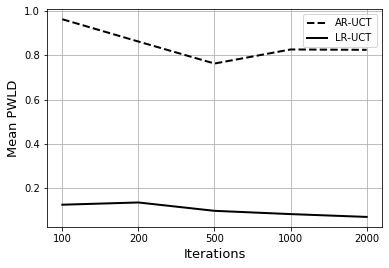

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


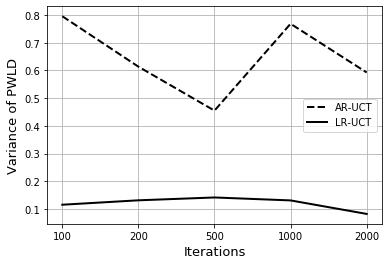

In [37]:
import matplotlib.pyplot as plt

def draw(ave_mean_path, best_mean_path, y_title):
    fig = plt.figure()
    ax = plt.subplot()
    bs = plt.subplot()
    labels = [100, 200, 500, 1000, 2000]
    plt.xticks(np.arange(0, 5, 1.0))
    ax.set_xticklabels(labels)
    AX, = ax.plot(ave_mean_path, linestyle='--', alpha=1.0, color='black', linewidth=2.0)
    BS, = bs.plot(best_mean_path, alpha=1.0, color='black', linewidth=2.0)
    plt.xlabel("Iterations",fontsize=13)
    plt.ylabel(y_title, fontsize=13)
    plt.grid()
    plt.legend([AX, BS],['AR-UCT', 'LR-UCT'])
    fig.savefig("UCT_LRUCT"+y_title+".eps", bbox_inches='tight')
    plt.show()

draw(ave_mean, best_mean, "Mean PWLD")
draw(ave_std, best_std, "Variance of PWLD")

In [27]:
def draw_board(paths_x, paths_y, board, save_name):
    
    import matplotlib.pyplot as plt
    width, height = board.shape

    # create a 8" x 8" board
    fig = plt.figure(figsize=[8,8])
    # fig.patch.set_facecolor((1,1,.8))

    ax = fig.add_subplot(111)

    # draw the grid
    for x in range(30):
        ax.plot([x, x], [0,29], color=(0.5,0.5,0.5,1))
    for y in range(30):
        ax.plot([0, 29], [y,y], color=(0.5,0.5,0.5,1))

    # draw paths
    for p in range(len(paths_x)):

        ph = plt.subplot()
        ph.plot(paths_y[p], paths_x[p], linewidth=5, color='black')

    # draw obstacles
    x_axis = []
    y_axis = []
    nets = dict()
    for x in range(width):
        for y in range(height):
            if board[x, y]!=0:
                x_axis.append(y)
                y_axis.append(x)
                if board[x, y]!=1:
                    nets[(x,y)] = board[x, y]

    ax.scatter(x_axis, y_axis, marker='s', s=250, c='k')

    for xy in nets:
        ax.text(xy[1], xy[0], str(int(nets[xy])-1), fontsize=18, color='w',
                horizontalalignment='center', verticalalignment='center')

    # scale the axis area to fill the whole figure
    ax.set_position([0,0,1,1])

    # get rid of axes and everything (the figure background will show through)
    ax.set_axis_off()

    # scale the plot area conveniently (the board is in 0,0..18,18)
    ax.set_xlim(0,29)
    ax.set_ylim(0,29)
    
    fig.savefig(save_name, bbox_inches='tight')
    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


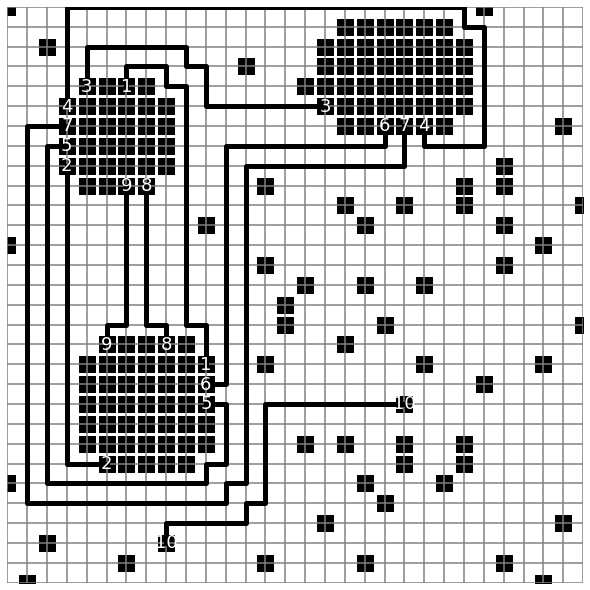

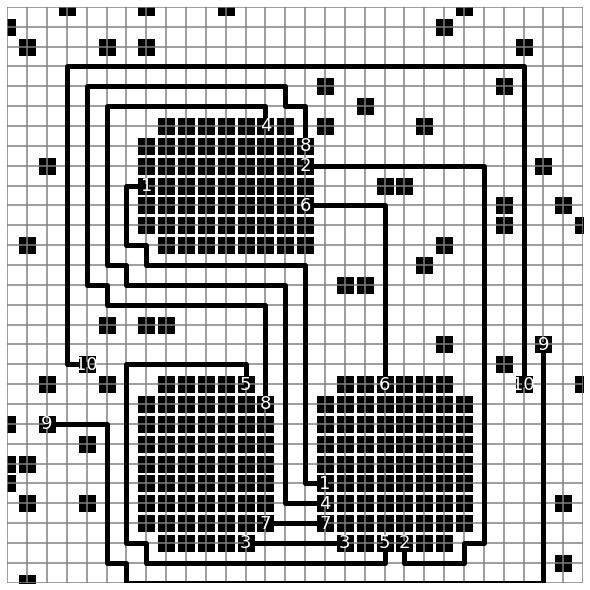

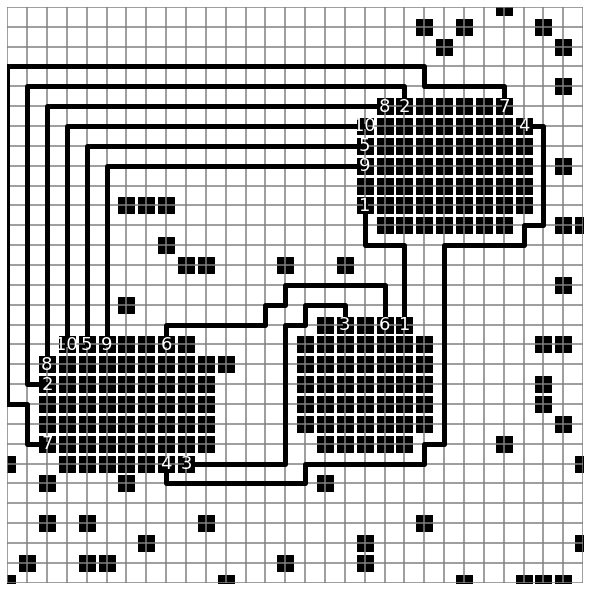

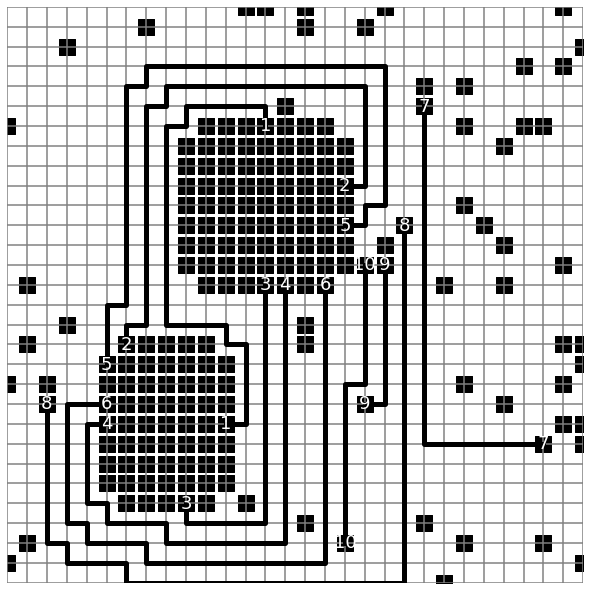

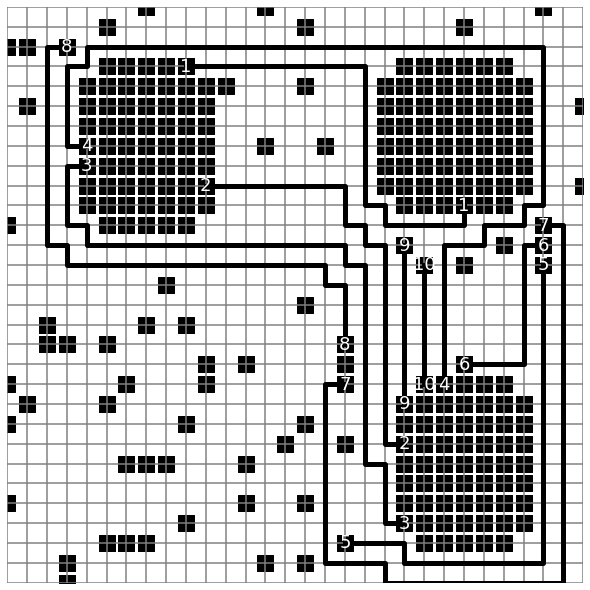

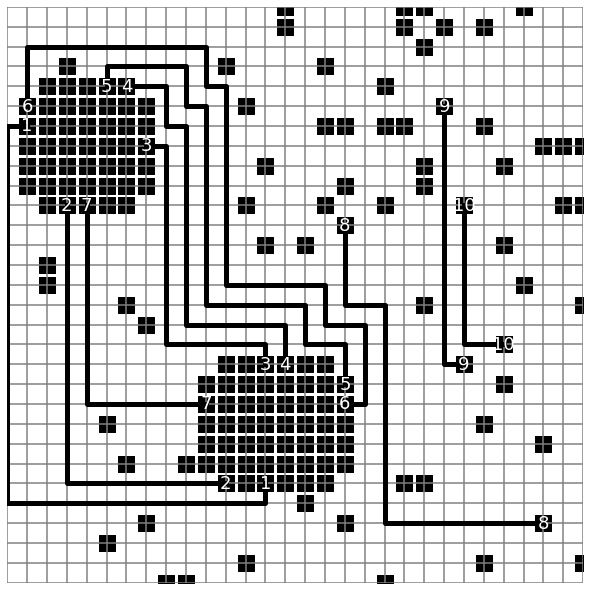

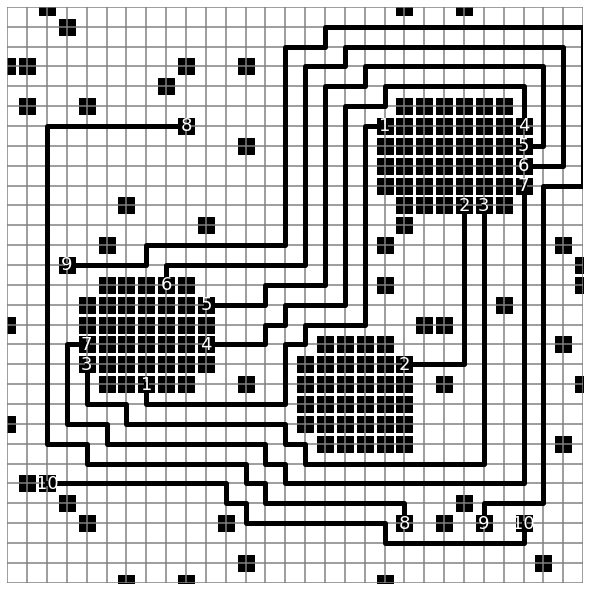

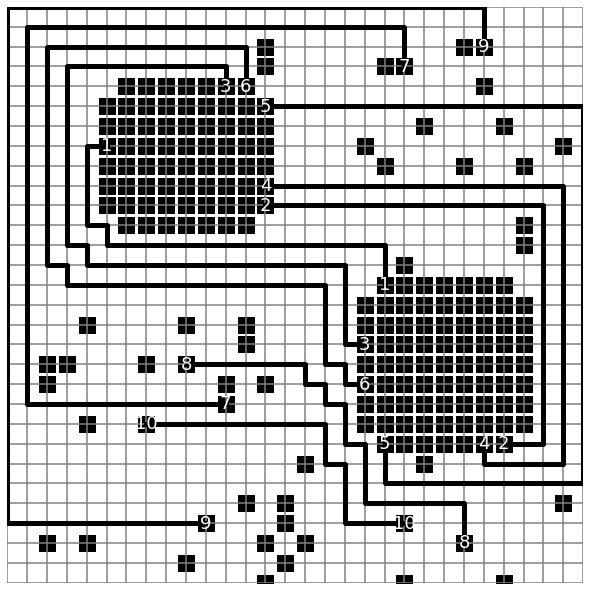

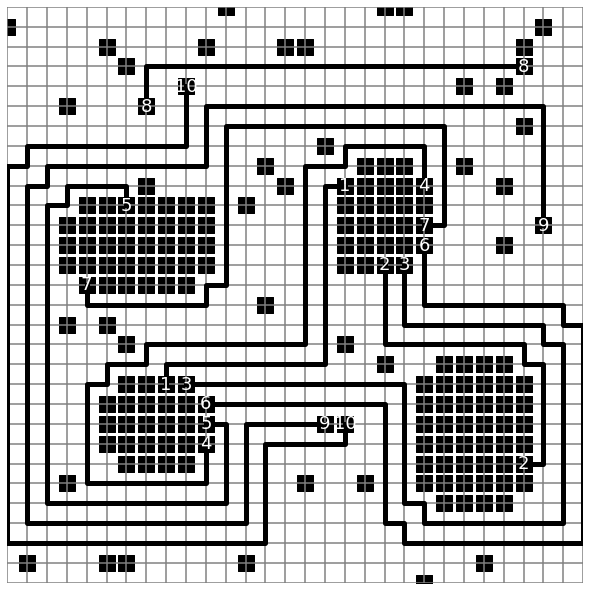

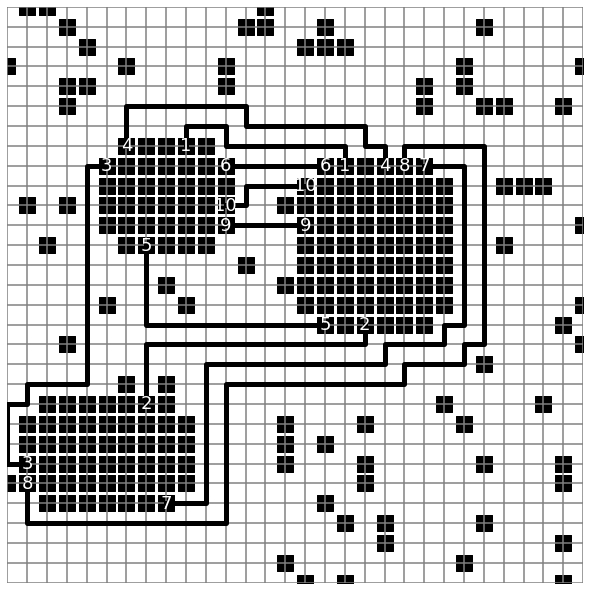

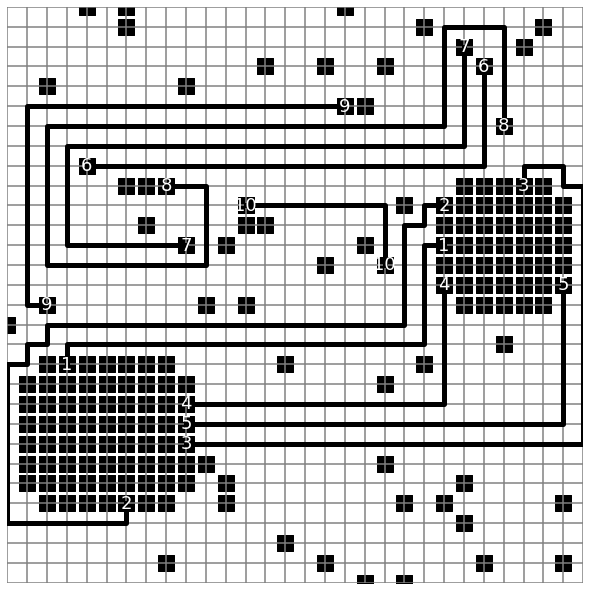

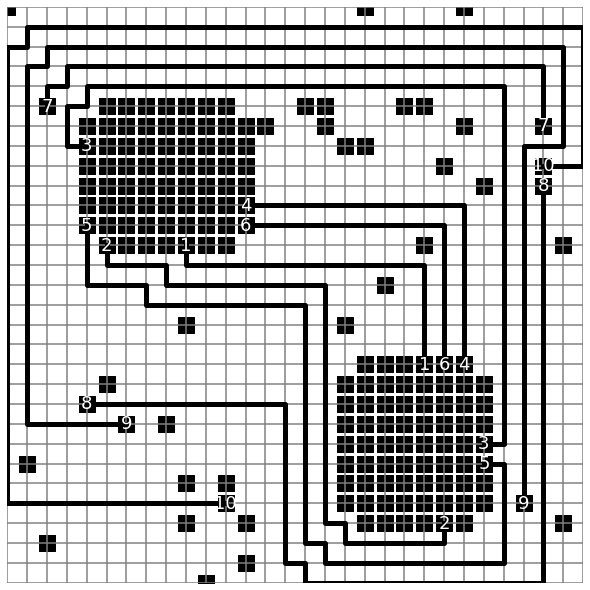

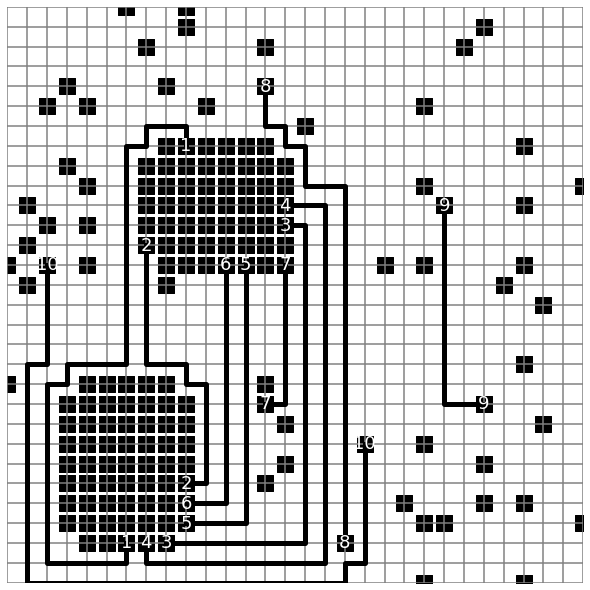

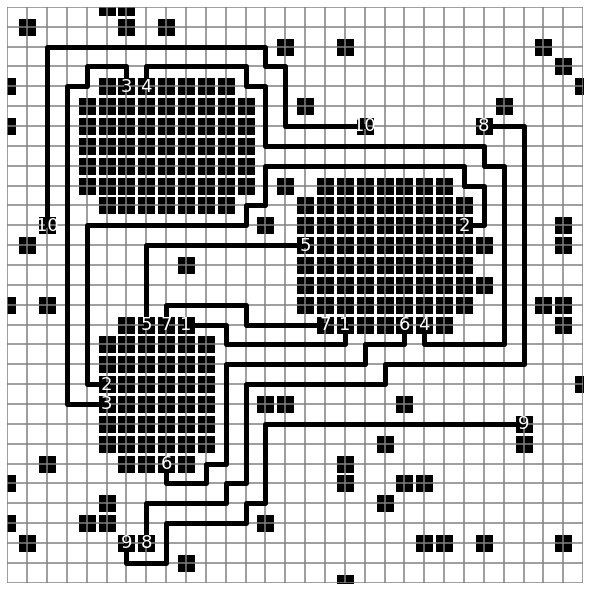

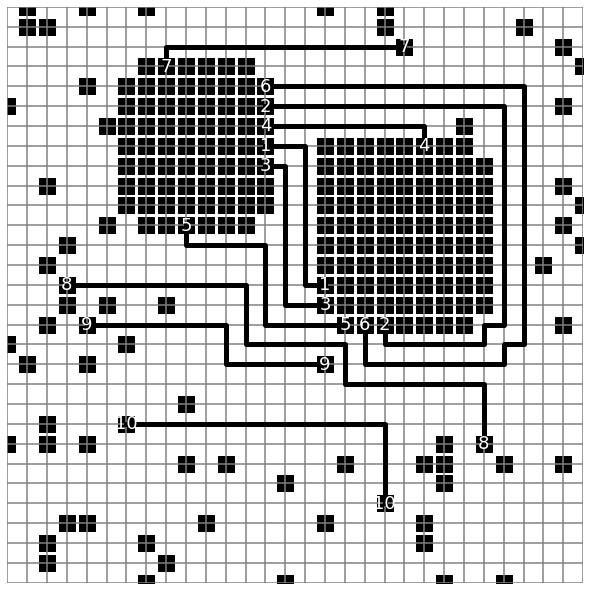

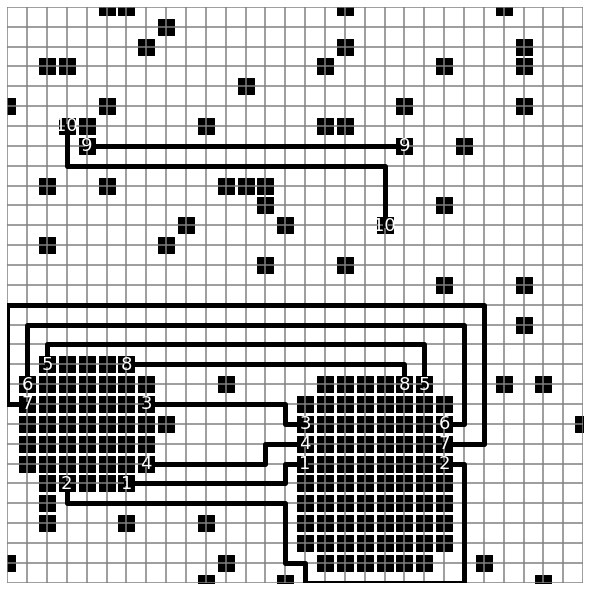

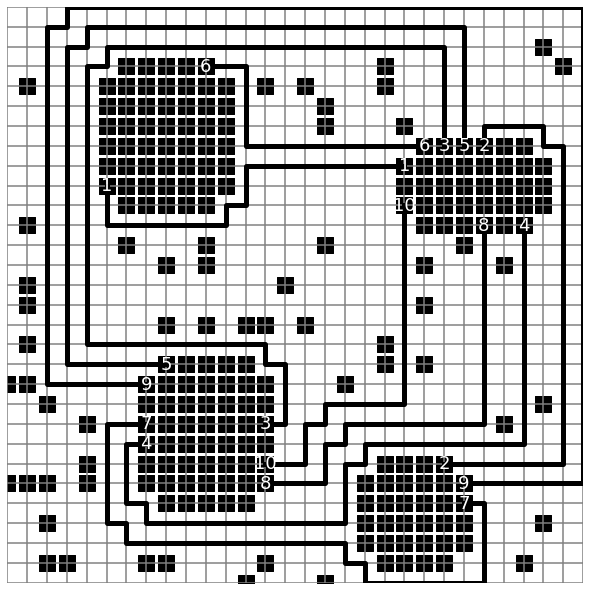

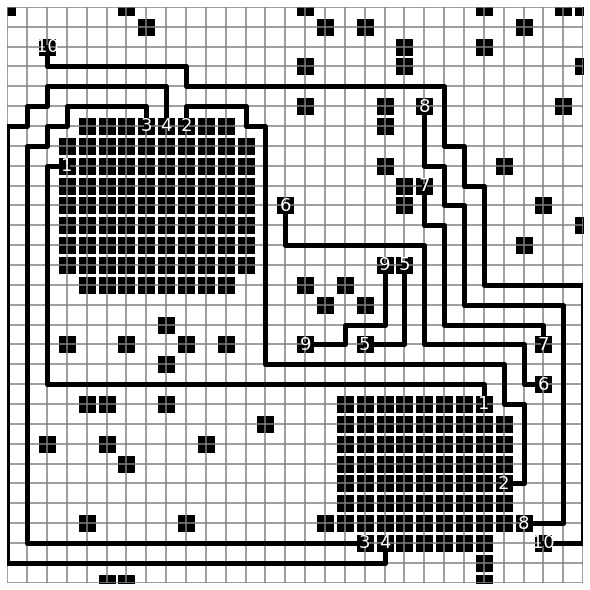

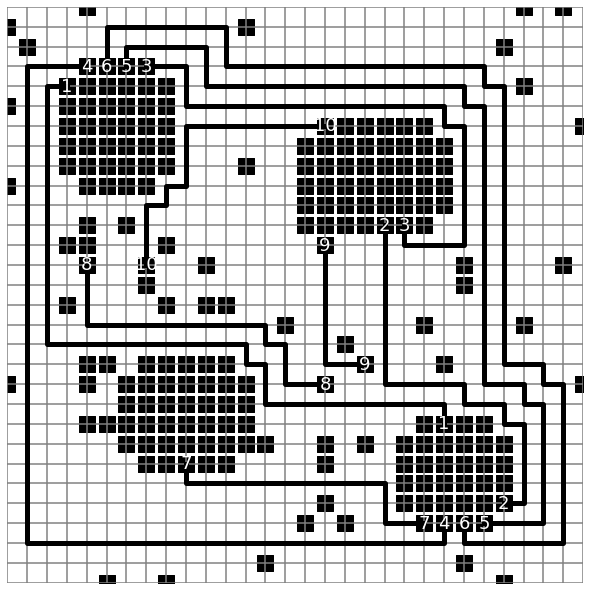

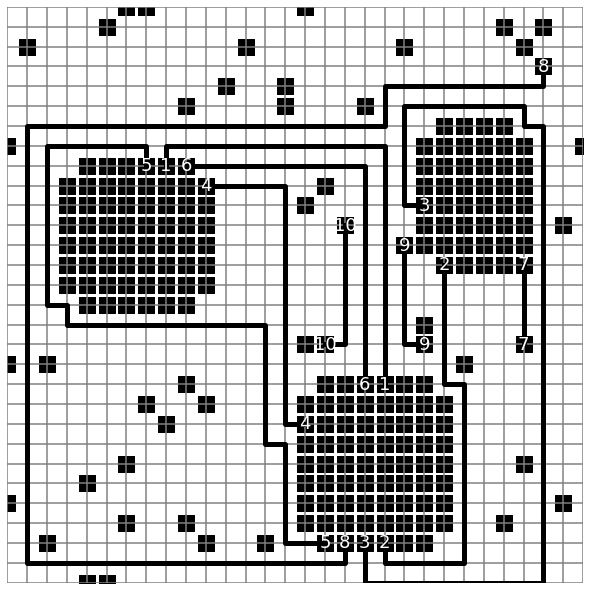

In [33]:
# print shortest path by Lee's algorithm
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/home/ybiao/DRL4CR/LearnFromMazeAlgm/')

from LeeAlgm import Field
import numpy as np
import matplotlib.pyplot as plt
import os
import re

class MazeRouting_showPath():

    def __init__(self):

        self.board = np.zeros((30,30))

        self.barriers = []
        self.start = {}
        self.finish = {}

        self.data_idx = 0

        self.pin_max = int(np.amax(self.board))

        self.labels = []

        self.direction_map = {(-1, 0): 0, (0, 1): 1, (1, 0): 2, (0, -1): 3}

    def parseBoard(self):
        ''' Get the initial barriers from the board including terminals,
            and also get the start and end of the routing path (terminals).
        '''

        for i in range(self.board.shape[0]):
            for j in range(self.board.shape[1]):
                if self.board[i,j] == 1:
                    self.barriers.append((i,j))
                elif self.board[i,j] != 0:
                    if self.board[i,j]<0:
                        self.finish[-self.board[i,j]] = (i,j)
                    else:
                        self.start[self.board[i,j]] = (i,j)
                    self.barriers.append((i,j))

    def GenRoutingData(self, path):
        ''' Given the routing path by maze algorithm of one pair of terminals,
            generate and save the data for RL: the number in the path increase as the path gets longer, \
            and other blocks on the board are 1s
        '''
        path_x = []
        path_y = []
        path_num = self.pin_max + 1

        for p in range(len(path)-1):
            # generate board
            self.barriers.append(path[p])
            self.board[path[p]] = path_num
            path_x.append(path[p][0])
            path_y.append(path[p][1])
            path_num += 1

        self.board[(path_x, path_y)] = 1
                    
    def getRoutingPath(self, pin_idx):

        self.barriers.remove(self.start[pin_idx])
        self.barriers.remove(self.finish[pin_idx])

        field = Field(len=30, start=self.start[pin_idx], finish=self.finish[pin_idx],
                      barriers=self.barriers)
        field.emit()

        path = field.get_path()
        
        self.barriers.append(self.start[pin_idx])
        self.barriers.append(self.finish[pin_idx])
        
        return list(path)

    def run(self, filename):

        self.parseBoard()
        route_path = []
        
        sign = False
        for pin_idx in range(2, 12):
            try:
                path = self.getRoutingPath(pin_idx)
                route_path.append(path)
                self.GenRoutingData(path)
            except:
                print(filename)
                sign = True
        return route_path, sign

    def reset(self, board):

        self.board = board

        self.barriers = []
        self.start = {}
        self.finish = {}

        self.data_idx = 0

        self.pin_max = int(np.amax(board))

        self.labels = []

def abs_pin(board):
    for i in range(board.shape[0]):
        for j in range(board.shape[1]):
            board[i,j] = abs(board[i,j])
    return board
    
# for idx in [0,1,2,3,4,5,6,7,8,9,10,11,12,14,15,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]:
for idx in range(20):  
    filename = "board"+str(idx)+".csv"
    foldername = '../../GenPlacement/new_boards/'
    Bpath = foldername + filename
    board = np.genfromtxt(Bpath, delimiter=',')
    routing = MazeRouting_showPath()
    # find the shortest path length
    routing.reset(board)
    shortest_path, sign = routing.run(Bpath)
#     if sign:
#         fail_num += 1
    #     print(shortest_path)


    # drawing paths
    paths_x = []
    paths_y = []
    for connection in shortest_path:
        pathx_tem = []
        pathy_tem = []
        for i in connection:
            pathx_tem.append(i[0])
            pathy_tem.append(i[1])
        paths_x.append(pathx_tem)
        paths_y.append(pathy_tem)

    board = np.genfromtxt(Bpath, delimiter=',')
    board = abs_pin(board)
    draw_board(paths_x, paths_y, board, "./Acannot/seqrouting_Lee"+str(idx)+".svg")

In [1]:
# draw routing results of A* algorithm
import sys

import numpy as np
import matplotlib.pyplot as plt
import os
import re
from astar import astar

def parseBoard(board):
    ''' Get the initial barriers from the board including terminals,
        and also get the start and end of the routing path (terminals).
    '''
#     board_list = np.transpose(board).tolist()
    board_list = board.tolist()
    barriers = []
    start = {}
    finish = {}
    for i in range(board.shape[0]):
        for j in range(board.shape[1]):
            if board[i,j] == 1:
                barriers.append((i,j))
                board_list[i][j] = None
            elif board[i,j] != 0:
                board_list[i][j] = None
                if board[i,j] in start:
                    finish[board[i,j]] = (i,j)
                else:
                    start[board[i,j]] = (i,j)
                barriers.append((i,j))
    return board_list, start, finish, barriers  

filename = "board23.csv"
foldername = '../server_code/test_boards/'
Bpath = foldername + filename
board = np.genfromtxt(Bpath, delimiter=',')

board_list, start, finish, barriers = parseBoard(board)
# print(board_list)
paths_x = []
paths_y = []
for s in range(2,7):
    board_list[start[s][0]][start[s][1]] = 0
    board_list[finish[s][0]][finish[s][1]] = 0

    path = astar(board_list, start[s], finish[s])
    print(start[s], finish[s])
    print(path)
    pathx = []
    pathy = []
    if path is not None:
        for p in path:
            pathx.append(p[0])
            pathy.append(p[1])
            board_list[p[0]][p[1]] = None
        paths_x.append(pathx)
        paths_y.append(pathy)

board = np.genfromtxt(Bpath, delimiter=',')
# draw_board(paths_x, paths_y, board, "./Acannot/seqrouting"+filename+".svg")

(3, 6) (9, 21)
[(3, 6), (3, 7), (3, 8), (2, 8), (2, 9), (2, 10), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (4, 16), (4, 17), (5, 17), (5, 18), (6, 18), (6, 19), (7, 19), (7, 20), (8, 20), (8, 21), (9, 21)]
(5, 4) (21, 8)
[(5, 4), (6, 4), (6, 5), (7, 5), (8, 5), (9, 5), (10, 5), (11, 5), (12, 5), (13, 5), (14, 5), (15, 5), (16, 5), (17, 5), (18, 5), (18, 6), (19, 6), (19, 7), (20, 7), (20, 8), (21, 8)]
(3, 9) (9, 19)
None
(6, 8) (11, 17)
[(6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (7, 13), (7, 14), (8, 14), (8, 15), (9, 15), (9, 16), (10, 16), (10, 17), (11, 17)]
(14, 24) (20, 12)
[(14, 24), (14, 23), (14, 22), (14, 21), (14, 20), (14, 19), (14, 18), (14, 17), (15, 17), (15, 16), (16, 16), (16, 15), (17, 15), (17, 14), (18, 14), (18, 13), (19, 13), (19, 12), (20, 12)]


NameError: name 'draw_board' is not defined

In [15]:
# For plotting routing path curve
import os
import numpy as np

def Read_Data_From_File(file_path):

    data = []
    for filename in os.listdir(file_path):
        
        sequence = np.loadtxt(file_path+filename, delimiter=",")
        data.append(sequence.shape[0]-1)
                
    return data

def AllPathLen(policy_type):
    routing_paths = []
    iterations = ["1000_001", "1000_005", "1000_01", "1000_1"]
    for i in iterations:
        file_path = "./Actions_"+policy_type+i+"/"
        routing_paths.append(Read_Data_From_File(file_path))
    return routing_paths

def draw(ave_mean_path, best_mean_path):
    fig = plt.figure()
    ax = plt.subplot()
    bs = plt.subplot()
    labels = [0, 100, 200, 500, 1000, 2000]
    ax.set_xticklabels(labels)
    AX, bars_ave= ax.plot(ave_mean_path, '--', alpha=1.0, color='black', linewidth=2.0)
    BS, bars_best= bs.plot(best_mean_path, alpha=1.0, color='black', linewidth=2.0)
    plt.xlabel("Iterations",fontsize=13)
    plt.ylabel("Routing path length", fontsize=13)
    plt.grid()
    plt.legend([AX, BS],['UCB1', 'RUCB1'])
    fig.savefig("UCB_RUCB.eps", bbox_inches='tight')
    plt.show()

import matplotlib.pyplot as plt

# ave_path_len = np.array(AllPathLen("ave"))
# print(type(ave_path_len[0]))
# ave_mean_path = np.mean(ave_path_len, axis=1)

best_path_len = np.array(AllPathLen("best"))

# best_mean_path = np.mean(best_path_len, axis=1)
for pl in best_path_len:
    print(sum(pl)/len(pl))

# draw(best_mean_path, best_mean_path)

101.0
89.74358974358974
84.94871794871794
88.53846153846153


[[3, 2, 2, 2, 2, 2, 1, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 3, 4, 5, 5, 5, 6, 7, 7, 8, 8, 9], [5, 6, 6, 7, 8, 8, 9, 10, 10, 11, 12, 13, 14, 15, 15, 16, 17, 18, 19, 20, 21], [3, 3, 3, 4, 4, 5, 6, 7, 7, 7, 8, 8, 8, 8, 9, 9, 9], [6, 6, 6, 6, 7, 8, 8, 8, 9, 10, 11, 11, 11, 11, 11], [14, 15, 15, 16, 17, 17, 17, 18, 18, 18, 18, 19, 20, 20, 20, 20, 20, 20, 20]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


0


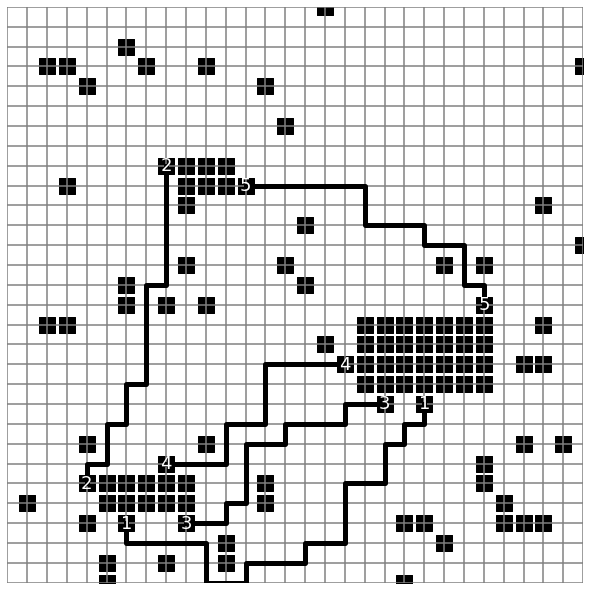

In [14]:
# For plotting routing path on the board
from testAction import test_policy
import numpy as np
import matplotlib.pyplot as plt
import os
import re

def checkNeigh(cood1, cood2):
    direction_list = [(-1, 0), (0, 1), (1, 0), (0, -1)]
    for d in direction_list:
        if (cood1[0]+d[0], cood1[1]+d[1]) == cood2:
            return True
    return False

# getting path
direction_list = [(-1, 0), (0, 1), (1, 0), (0, -1)]

num_fails = 0
for idxB in [23]:
# for idxB in [0,1,2,3,4,5,6,7,8,9,10,11,12,14,15,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]:
    
    boardfile = '../server_code/test_boards/board'+str(idxB)+'.csv'
    board = np.genfromtxt(boardfile, delimiter=',')
    initialState = test_policy(board)

    start = initialState.start
    finish = initialState.finish

    pair_idx = 2
    
    try:
        actions = np.genfromtxt("./Actions_best5000/saved_actions_"+str(idxB)+".csv", delimiter=',')
#         print(actions)

        paths_x = []
        paths_y = []

        path_x = [initialState.start[pair_idx][0]]
        path_y = [initialState.start[pair_idx][1]]
        act_idx = 1

        for action_idx in actions:

            action = direction_list[int(action_idx)]
            initialState.takeAction(action)

            if initialState.action_node is not None and pair_idx in finish:
                
#                 if act_idx in [33, 57, 73, 87, 105]:
                if checkNeigh(initialState.action_node, finish[pair_idx]):

                    path_x.append(initialState.action_node[0])
                    path_y.append(initialState.action_node[1])

                    path_x.append(finish[pair_idx][0])
                    path_y.append(finish[pair_idx][1])

                    pair_idx += 1
                    paths_x.append(path_x)
                    paths_y.append(path_y)

                    path_x = []
                    path_y = []

                else:
                    path_x.append(initialState.action_node[0])
                    path_y.append(initialState.action_node[1])
                
                act_idx += 1
#             initialState.takeAction(action)

        if len(paths_x)<5:
            paths_x.append(path_x)
            paths_y.append(path_y)
            num_fails += 1
#             print(idxB)

#         drawing board
        print(paths_x)
        board = np.genfromtxt(boardfile, delimiter=',')
        draw_board(paths_x, paths_y, board, "./routedboard"+str(idxB)+"_5000"".eps")
    except:
        print("the board is not in the folder")
        print(idxB)
print(num_fails)

# plot board without routing paths


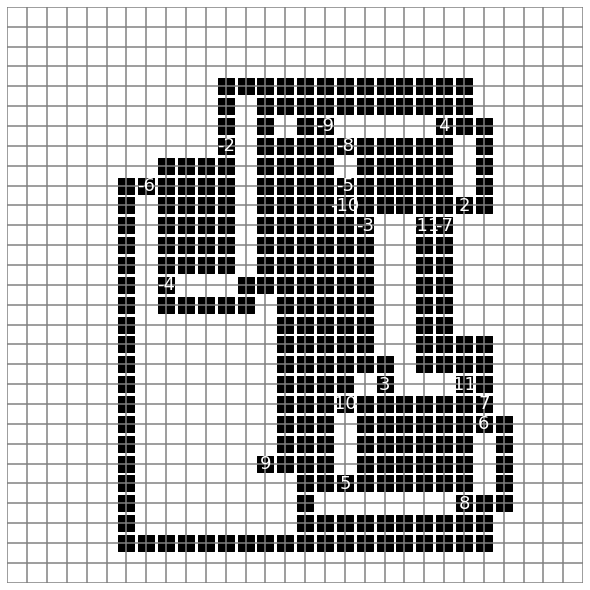

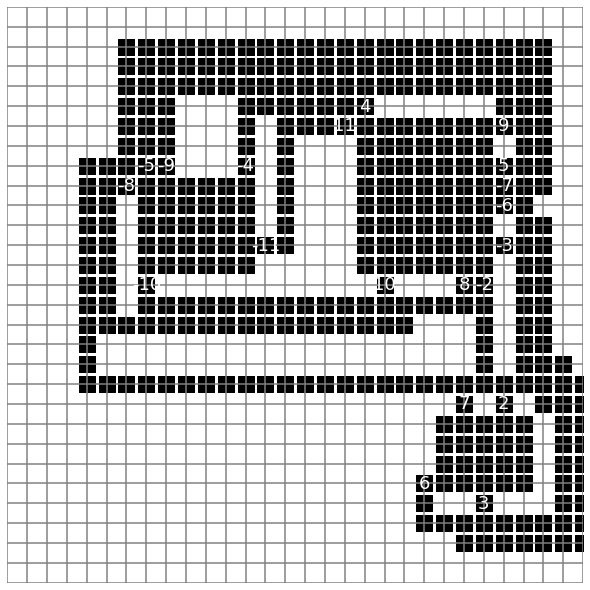

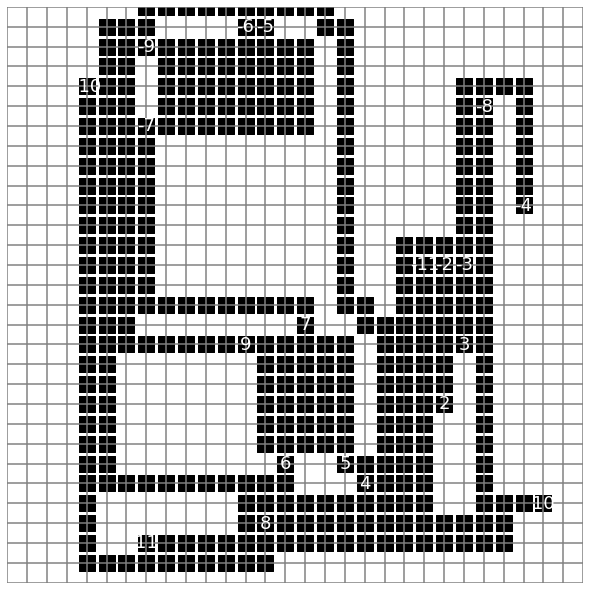

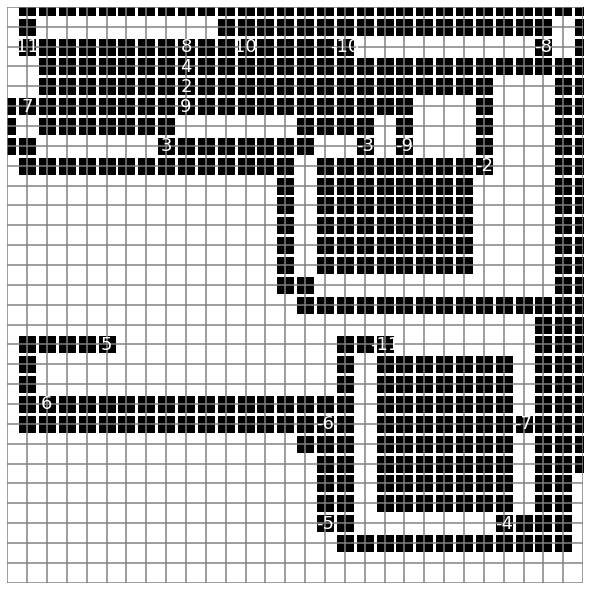

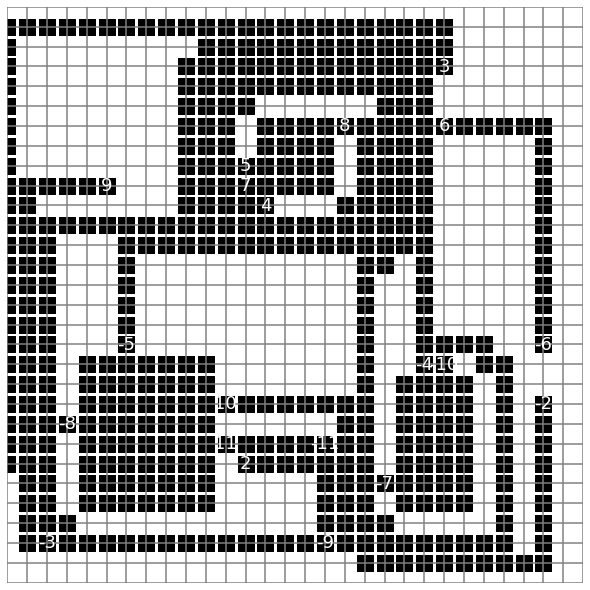

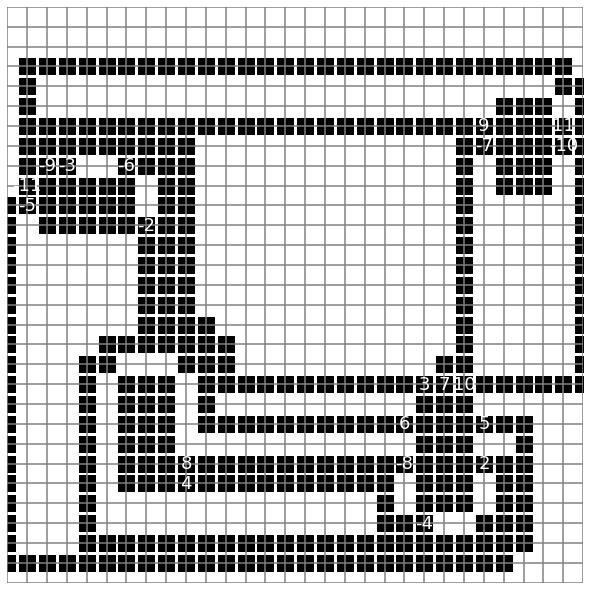

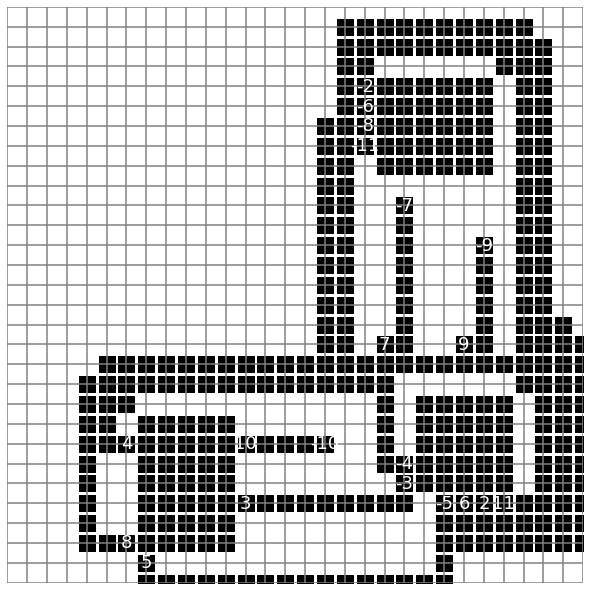

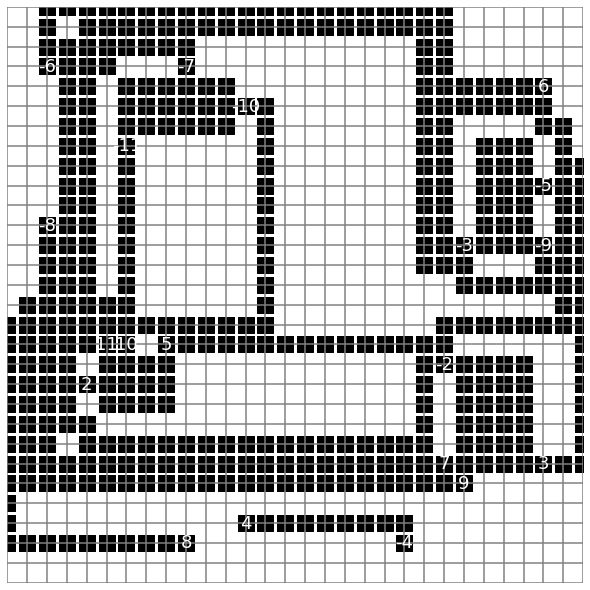

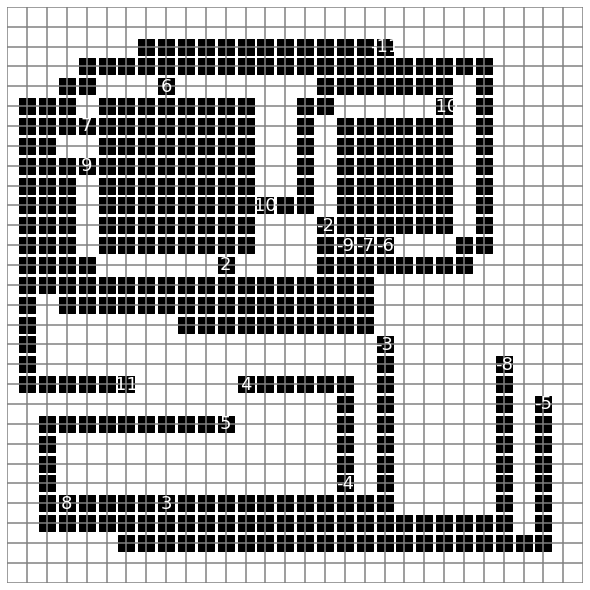

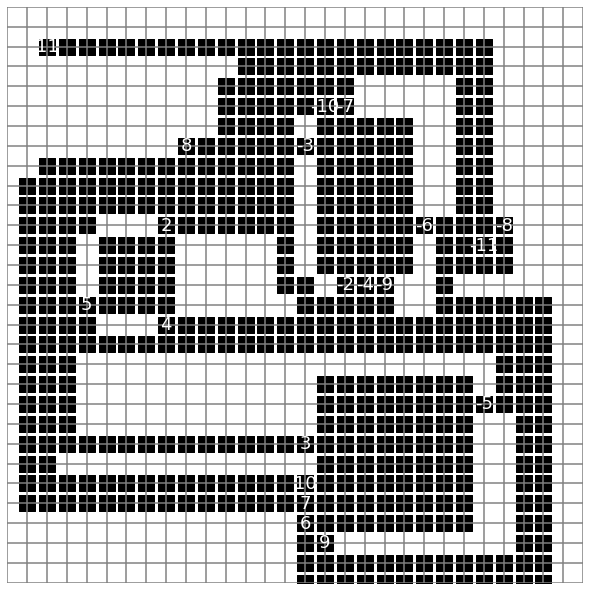

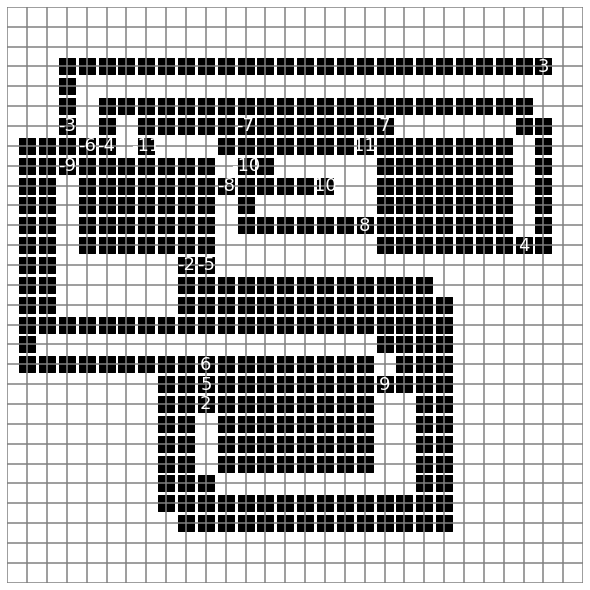

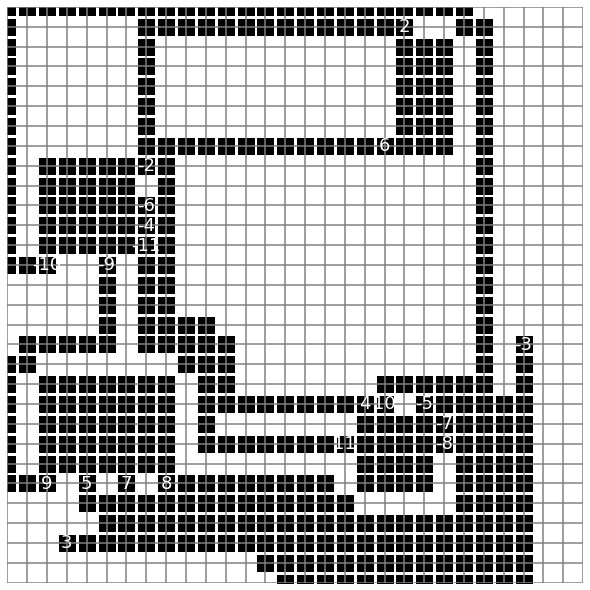

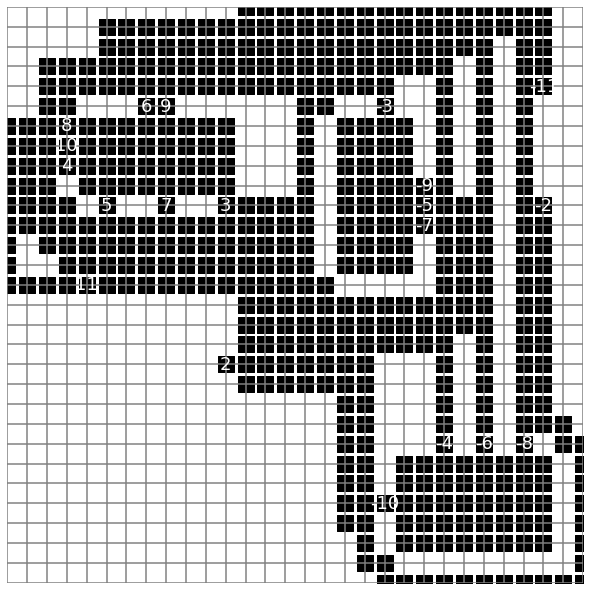

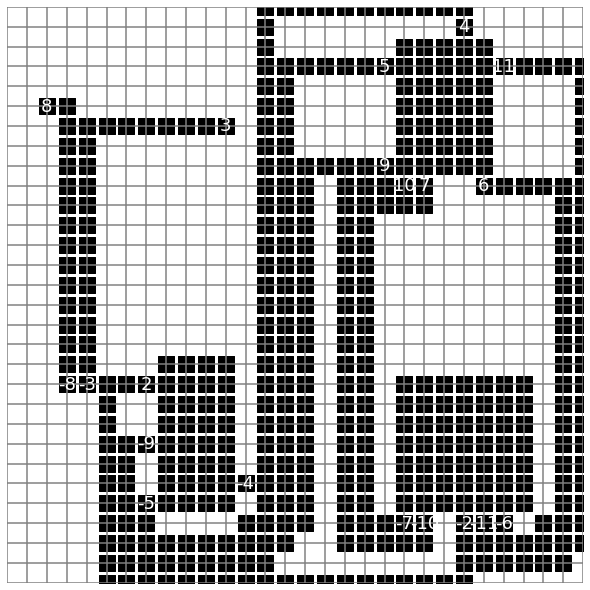

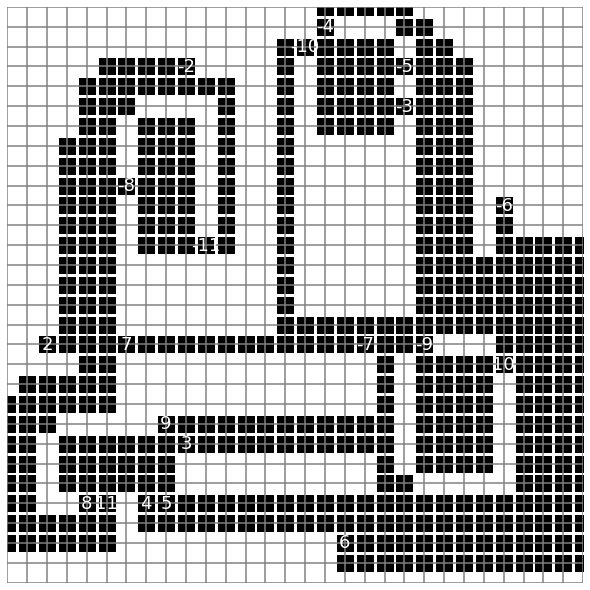

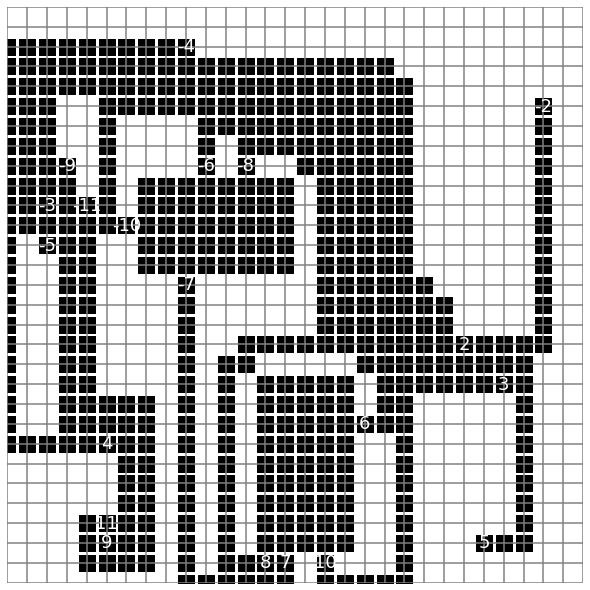

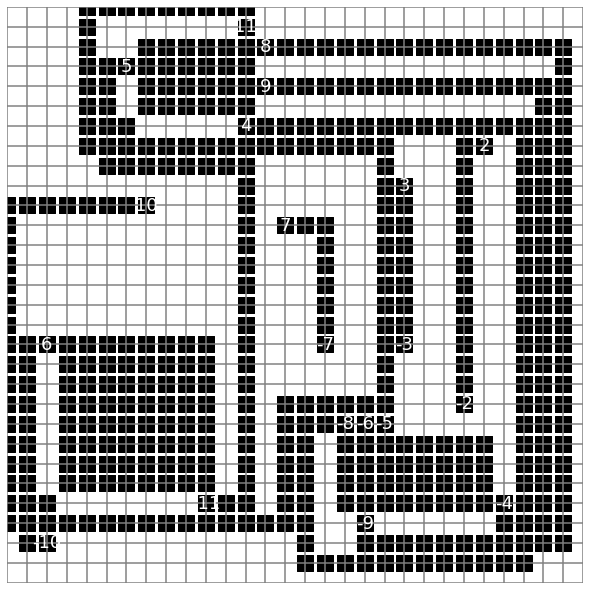

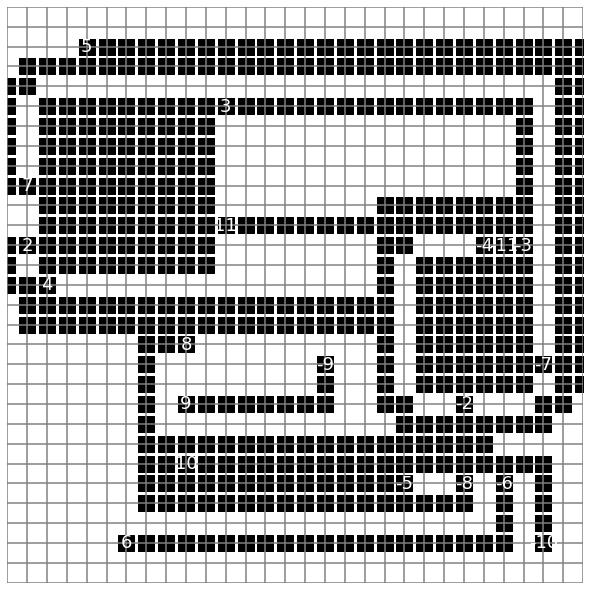

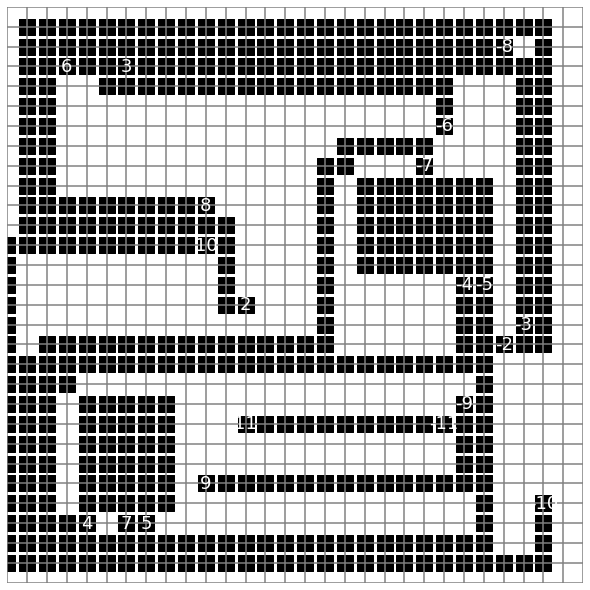

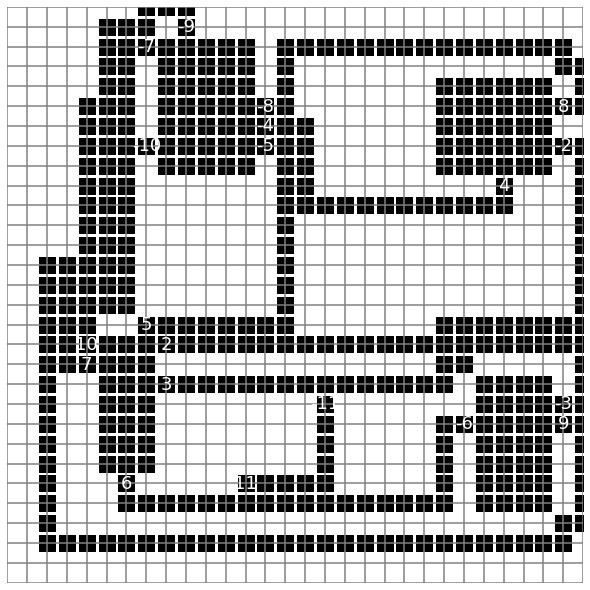

In [29]:
def draw_gen_board(board, save_name):
    
    import matplotlib.pyplot as plt
    width, height = board.shape

    # create a 8" x 8" board
    fig = plt.figure(figsize=[8,8])
    # fig.patch.set_facecolor((1,1,.8))

    ax = fig.add_subplot(111)

    # draw the grid
    for x in range(30):
        ax.plot([x, x], [0,29], color=(0.5,0.5,0.5,1))
    for y in range(30):
        ax.plot([0, 29], [y,y], color=(0.5,0.5,0.5,1))

    # draw obstacles
    x_axis = []
    y_axis = []
    nets = dict()
    for x in range(width):
        for y in range(height):
            if board[x, y]!=0:
                x_axis.append(y)
                y_axis.append(x)
                if board[x, y]!=1:
                    nets[(x,y)] = board[x, y]

    ax.scatter(x_axis, y_axis, marker='s', s=250, c='k')

    for xy in nets:
        ax.text(xy[1], xy[0], str(int(nets[xy])), fontsize=18, color='w',
                horizontalalignment='center', verticalalignment='center')

    # scale the axis area to fill the whole figure
    ax.set_position([0,0,1,1])

    # get rid of axes and everything (the figure background will show through)
    ax.set_axis_off()

    # scale the plot area conveniently (the board is in 0,0..18,18)
    ax.set_xlim(0,29)
    ax.set_ylim(0,29)
    
    fig.savefig(save_name, bbox_inches='tight')
    plt.show()

for idx in range(20):  
    filename = "board_path"+str(idx)+".csv"
    foldername = '../../GenPlacement/new_boards/'
    Bpath = foldername + filename
    board = np.genfromtxt(Bpath, delimiter=',')

    board = np.genfromtxt(Bpath, delimiter=',')
#     print(board)
    draw_gen_board(board, "./Acannot/seqrouting_Lee_path"+str(idx)+".svg")

In [36]:
filename = "training_data.csv"
foldername = '../../GenPlacement/new_boards/'
Bpath = foldername + filename
dataset = np.genfromtxt(Bpath, delimiter=',')
for i in range(dataset.shape[0]):
    
    board = np.reshape(dataset[i][:-1], (30,30))
    np.savetxt('../../GenPlacement/new_boards/board'+str(i)+'.csv', board, delimiter=',')